In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, ConfusionMatrixDisplay, roc_auc_score, recall_score, f1_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
import sklearn.pipeline
import util

In [3]:
def cat_feature_pvalue(cat_features):
    for cat_feature in cat_features:
        pd_tb = pd.crosstab(X[cat_feature], y)
        _, p, _, _ = chi2_contingency(pd_tb)
        print('The p-value for '+ cat_feature +' is {}'.format(p))

In [4]:
df1 = pd.read_csv('./data/application_record.csv')
df2 = pd.read_csv('./data/credit_record.csv')

In [5]:
df1.loc[df1.DAYS_EMPLOYED > 0, 'DAYS_EMPLOYED'] = 0
df1.drop(['FLAG_MOBIL'], axis=1, inplace=True)
df1.drop(['CNT_CHILDREN'], axis=1, inplace=True)
df1['OCCUPATION_TYPE'].fillna('others', inplace=True)

In [6]:
df2['status_label'] = None
df2.loc[df2.STATUS=='2', ['status_label']] = 1
df2.loc[df2.STATUS=='3', ['status_label']] = 1
df2.loc[df2.STATUS=='4', ['status_label']] = 1
df2.loc[df2.STATUS=='5', ['status_label']] = 1
df2_label = df2.groupby('ID').count()
df2_label['ID'] = df2_label.index
df2_label['window'] = df2.groupby('ID').MONTHS_BALANCE.max() - df2.groupby('ID').MONTHS_BALANCE.min()
df2_label.reset_index(drop=True, inplace=True)
df2_label.loc[df2_label.status_label>0, ['label']] = 1
df2_label.loc[df2_label.status_label==0, ['label']] = 0

In [7]:
df = pd.merge(df1, df2_label, how='left', on='ID')

In [8]:
df.dropna(inplace=True)
df_3m = df.loc[df.window >= 3]
target = 'label'

In [9]:
cat_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']
num_features = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
features = cat_features + num_features

In [10]:
X = df_3m[features].copy()
y = df_3m[target].copy()

## Categorical feature analysis: chi2

In [11]:
cat_feature_pvalue(cat_features)

The p-value for CODE_GENDER is 0.004200818250163816
The p-value for FLAG_OWN_CAR is 0.31094673353684066
The p-value for FLAG_OWN_REALTY is 3.765138844990331e-05
The p-value for NAME_INCOME_TYPE is 0.022267276017069394
The p-value for NAME_EDUCATION_TYPE is 0.1614950971094055
The p-value for NAME_FAMILY_STATUS is 5.05343017771654e-05
The p-value for NAME_HOUSING_TYPE is 0.041532024076485013
The p-value for FLAG_WORK_PHONE is 0.3338937185822779
The p-value for FLAG_PHONE is 0.8508719434245687
The p-value for FLAG_EMAIL is 0.6196849939142168
The p-value for OCCUPATION_TYPE is 0.002783992081995003


**Chi2-test**  
Drop features with too big p-value:
- FLAG_PHONE
- FLAG_EMAIL
- FLAG_WORK_PHONE
- FLAG_OWN_CAR

In [12]:
features.remove('FLAG_PHONE')
features.remove('FLAG_EMAIL')
features.remove('FLAG_WORK_PHONE')
features.remove('FLAG_OWN_CAR')

In [13]:
X = df_3m[features].copy()
X = X.reset_index()

Clean data for modelling

In [14]:
# Categorical features
education_ordinal = OrdinalEncoder(
    categories=[['Lower secondary', 'Secondary / secondary special', 'Incomplete higher',
                 'Higher education', 'Academic degree']])
X['education'] = education_ordinal.fit_transform(X[['NAME_EDUCATION_TYPE']])

ordinal = OrdinalEncoder(categories=[['N', 'Y']])
X['property'] = ordinal.fit_transform(X[['FLAG_OWN_REALTY']])

In [15]:
X = pd.concat([X, util.Dummy_Transformer('income_').fit_transform(X['NAME_INCOME_TYPE'])], axis=1)
X = pd.concat([X, util.Dummy_Transformer('housing_').fit_transform(X['NAME_HOUSING_TYPE'])], axis=1)
X = pd.concat([X, util.Dummy_Transformer('occupation_').fit_transform(X['OCCUPATION_TYPE'])], axis=1)
X = pd.concat([X, util.Dummy_Transformer('marital_').fit_transform(X['NAME_FAMILY_STATUS'])], axis=1)
X = pd.concat([X, util.Dummy_Transformer('gender_').fit_transform(X['CODE_GENDER'])], axis=1)

In [16]:
# Numerical features
X = X.rename(columns={'AMT_INCOME_TOTAL': 'annual_income',
                      'DAYS_BIRTH': 'birthday', 'DAYS_EMPLOYED': 'days_employment',
                      'CNT_FAM_MEMBERS': 'family_size'})

X = X.rename(columns={'gender_F': 'gender'})

In [17]:
num_features = ['annual_income', 'birthday', 'days_employment', 'family_size']
cat_features = ['property', 'education', 'gender',
                'income_Student', 'income_Pensioner', 'income_State servant',
                'income_Commercial associate', 'income_Working',
                'housing_Municipal apartment', 'housing_With parents',
                'housing_Office apartment', 'housing_Rented apartment',
                'housing_House / apartment', 'housing_Co-op apartment',
                'occupation_Cleaning staff', 'occupation_others',
                'occupation_Security staff', 'occupation_Medicine staff',
                'occupation_Managers', 'occupation_Sales staff',
                'occupation_Cooking staff', 'occupation_Core staff',
                'occupation_Laborers', 'occupation_Low-skill Laborers',
                'occupation_Waiters/barmen staff', 'occupation_IT staff',
                'occupation_Accountants', 'occupation_Secretaries',
                'occupation_High skill tech staff', 'occupation_Drivers',
                'occupation_Realty agents', 'occupation_Private service staff',
                'marital_Single / not married',
                'marital_Married', 'marital_Civil marriage', 'marital_Separated', 'marital_Widow']

In [18]:
X = X[num_features + cat_features].copy()

In [19]:
scaler = ColumnTransformer(
    transformers=[('num_scaler', StandardScaler(), num_features)],
    remainder='passthrough'
)

## Try new features
### Logistic Regression

In [21]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.0001, max_iter=10000, n_jobs=-1))]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
print(scores)

Mean ROC AUC: 0.558
[0.54066678 0.54365962 0.53996441 0.57688095 0.56345818 0.5770781
 0.57986595 0.53335432 0.58384343 0.54576294]


- Tune

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [26]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, #C=0.01))]
                                      solver='sag',
                                      #tol=0.001, 
                                      max_iter=100000, 
                                     ))]
param = {#'model__solver': ['lbfgs', 'sag', 'saga', 'newton-cg'], #
         #'model__C': np.arange(0.01, 2, 0.05)  # 0.01
         'model__tol': [0.001, 0.01, 0.0001, 0.00001] #0.001
         #'model__max_iter': [10000, 100000, 1000, 10000000]
        }

scorer = make_scorer(roc_auc_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=5).fit(X_train, y_train)

print('Tunning results of Logistic Regression: ', model_tuned.best_params_)
print('Tunning results of Logistic Regression: ', model_tuned.best_score_)

Tunning results of Logistic Regression:  {'model__tol': 1e-05}
Tunning results of Logistic Regression:  0.507447978118802


- Cross Validation

Text(0.5, 1.0, 'Cross validation scores of Logistic Regression')

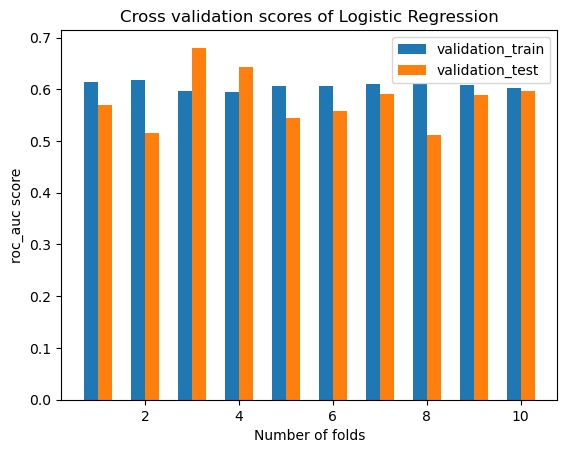

In [27]:
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE(random_state=1)), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.001, max_iter=100000, n_jobs=-1, random_state=1,
                                      solver='sag', C=0.01))]

lr_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                       scoring=('roc_auc'),
                       return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        lr_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        lr_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of Logistic Regression')

In [28]:
print('Train_score: ', lr_cv['train_score'])
print('Test_score: ', lr_cv['test_score'])
print('Train_mean_score: ', np.mean(lr_cv['train_score']))
print('Test_mean_score: ', np.mean(lr_cv['test_score']))

Train_score:  [0.61386128 0.61857325 0.59700648 0.59542473 0.60649877 0.60684045
 0.60957816 0.60966791 0.60761732 0.60285769]
Test_score:  [0.57000195 0.51565053 0.68031343 0.64278546 0.54423351 0.5572105
 0.59090832 0.51231112 0.5883758  0.59577009]
Train_mean_score:  0.6067926043767881
Test_mean_score:  0.5797560712286579


[0.61137035 0.61437969 0.59518854 0.59477104 0.60288922 0.60136232
 0.6066816  0.61060031 0.60563182 0.59854131]
[0.56394832 0.52393088 0.68916951 0.61540854 0.54672157 0.58839697
 0.58829957 0.49783592 0.59587173 0.62007894]
Train_mean_score:  0.6041416197205927
Test_mean_score:  0.5829661945024487


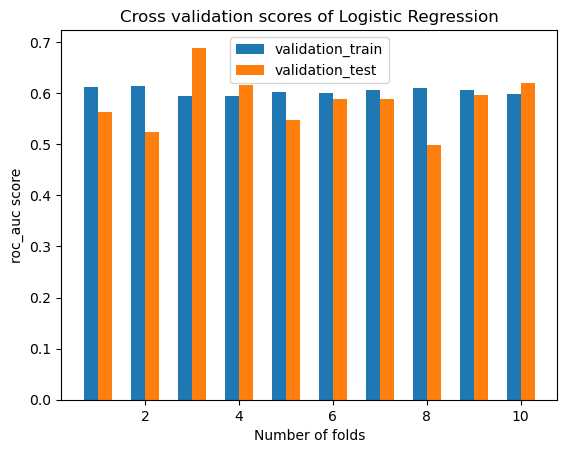

In [29]:
# check smote parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE(sampling_strategy=0.2, random_state=1)), 
         ('under', RandomUnderSampler(sampling_strategy=0.5)),
         ('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      solver='sag', C=0.01))]

lr_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                       scoring=('roc_auc'),
                       return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        lr_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        lr_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of Logistic Regression')

print(lr_cv['train_score'])
print(lr_cv['test_score'])
print('Train_mean_score: ', np.mean(lr_cv['train_score']))
print('Test_mean_score: ', np.mean(lr_cv['test_score']))

### XGBoost

- Tune

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=1,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                ))] 
                                 #min_child_weight=4))]
param = {#'model__learning_rate': [0.005, 0.05, 0.1, 0.5, 1],  # 1
         #'model__gamma': [0, 0.5, 1, 1.5, 2],  # 0
         #'model__max_depth': np.arange(3, 10),  # 5
         #'model__n_estimators': [100, 200, 250, 300, 400], # 250
         #'model__lambda': [1, 1.5, 2], # 1
         #'model__subsample': [1, 0.8], #0.8
         #'model__min_child_weight': np.arange(1, 10)  # 1
        }

scorer = make_scorer(roc_auc_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results: ', model_tuned.best_params_)
print('Tunning results of XGboost: ', model_tuned.best_score_)

Tunning results:  {'model__min_child_weight': 1}
Tunning results of XGboost:  0.6377962326665513


In [ ]:
0.6305630814674107
0.6393758180370175
0.6419263032802696

- Cross Validation

Train_score:  [0.63854062 0.63739407 0.63624201 0.62783392 0.6355768  0.62859675
 0.62623564 0.63322292 0.64168986 0.63043043]
Test_score:  [0.58035238 0.54326862 0.63705328 0.56670482 0.56775809 0.62511011
 0.59779865 0.49526104 0.52817116 0.58353097]
Train_mean_score:  0.6335763036216349
Test_mean_score:  0.5725009126198171


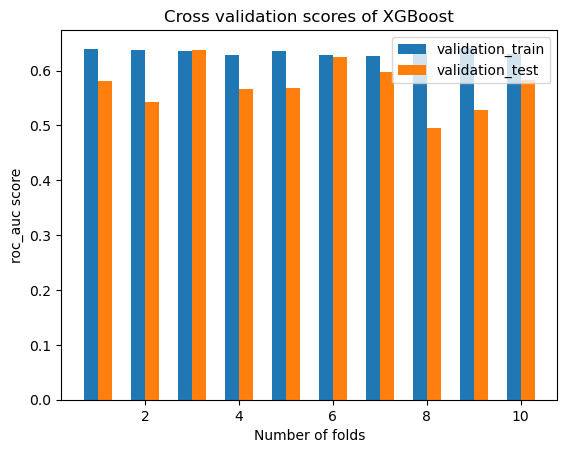

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE(random_state=1)), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=3, learning_rate=0.005,
                                 n_estimators=250,
                                 #min_child_weight=4, #reg_lambda=1,
                                 subsample=0.8,
                                ))] 

xgb_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                        scoring=('roc_auc'),
                        return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        xgb_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        xgb_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of XGBoost')

print('Train_score: ', xgb_cv['train_score'])
print('Test_score: ', xgb_cv['test_score'])
print('Train_mean_score: ', np.mean(xgb_cv['train_score']))
print('Test_mean_score: ', np.mean(xgb_cv['test_score']))

[0.69387153 0.70591914 0.6840665  0.70427677 0.69029037 0.67889512
 0.68463705 0.68563193 0.71093929 0.69097592]
[0.62106408 0.60008805 0.64311114 0.58600385 0.55303294 0.66352571
 0.61336224 0.56576941 0.5624873  0.605248  ]
Train_mean_score:  0.6929503619745703
Test_mean_score:  0.6013692736221696


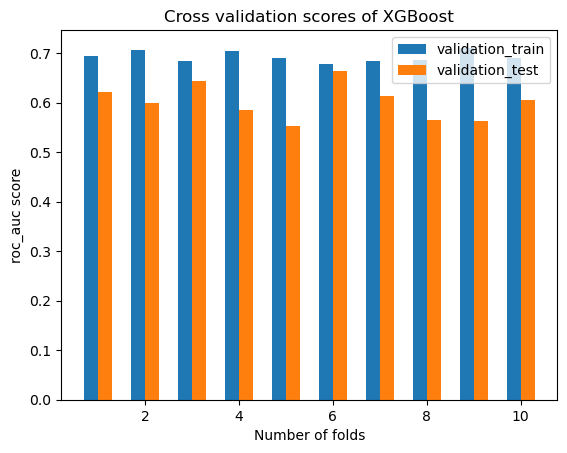

In [32]:
# tune smote
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE(sampling_strategy=0.2, random_state=1)), 
         ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=1)),
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=0.001,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                ))] 

xgb_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                        scoring=('roc_auc'),
                        return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        xgb_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        xgb_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of XGBoost')

print(xgb_cv['train_score'])
print(xgb_cv['test_score'])
print('Train_mean_score: ', np.mean(xgb_cv['train_score']))
print('Test_mean_score: ', np.mean(xgb_cv['test_score']))

### Try models on test dataset

Precision score:  0.0431266846361186
Recall score:  0.1038961038961039


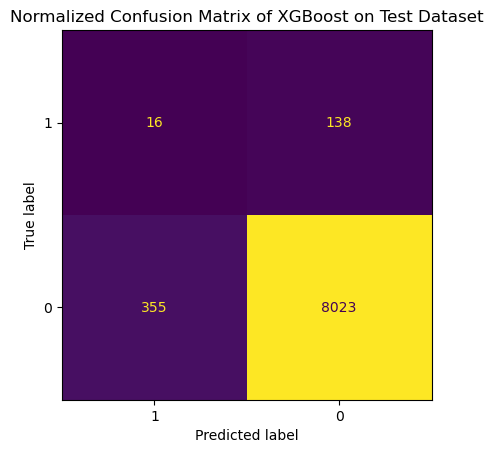

In [74]:
# XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

steps = [('over', SMOTE(random_state=1)), #sampling_strategy=0.2, 
         #('under', RandomUnderSampler(sampling_strategy=0.5, random_state=1)),
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=0.001,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                ))] 

model = Pipeline(steps).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0], #cmap=plt.cm.Paired,
                                      colorbar=False, 
                                      #normalize='all'
                                     )
plt.title('Normalized Confusion Matrix of XGBoost on Test Dataset')
print('Precision score: ', precision_score(y_test, y_test_pred))
print('Recall score: ', recall_score(y_test, y_test_pred))

Precision score:  0.05063291139240506
Recall score:  0.1038961038961039


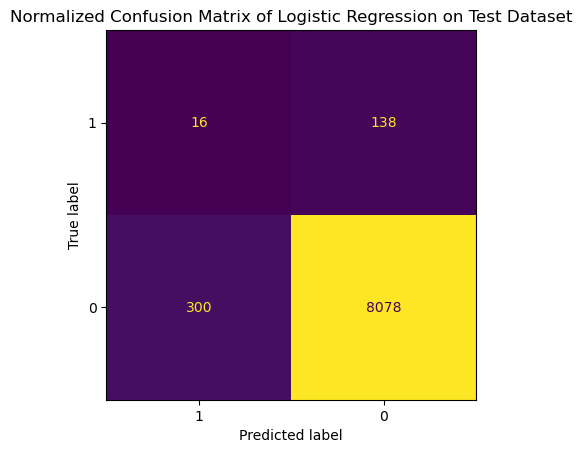

In [73]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

steps = [('over', SMOTE(random_state=1)), #sampling_strategy=0.2, 
         #('under', RandomUnderSampler(sampling_strategy=0.5)),
         ('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      solver='sag', C=0.01))]

model = Pipeline(steps).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0],
                                      colorbar=False, #cmap=plt.cm.flag,
                                      #normalize='all'
                                     )
plt.title('Normalized Confusion Matrix of Logistic Regression on Test Dataset')

y_test_pred = model.predict(X_test)
print('Precision score: ', precision_score(y_test, y_test_pred))
print('Recall score: ', recall_score(y_test, y_test_pred))

## Probability and threashold
### Logistic regression

In [35]:
def prob_threashold(y_test_proba, y_test):
    precision, recall, f1 = [], [], []
    thresholds = np.arange(0, 0.7, 0.01)
    for thresh in thresholds:
        y_test_pred = y_test_proba[:,1]>=thresh
        precision.append(precision_score(y_test, y_test_pred, zero_division=1))
        recall.append(recall_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
    
    
    plt.plot(thresholds, precision, linewidth=3, label='precision')
    plt.plot(thresholds, recall, linewidth=3, label='recall')
    plt.plot(thresholds, f1, linewidth=3, label='f1 score')
    plt.legend()
    plt.xlabel('threshold')
    #plt.axis('equal')
    plt.xlim(0, 0.8, 0.1)
    plt.ylim(0, 1, 0.1)

Text(0.5, 1.0, 'Probability Thresholds of Logistic Regression')

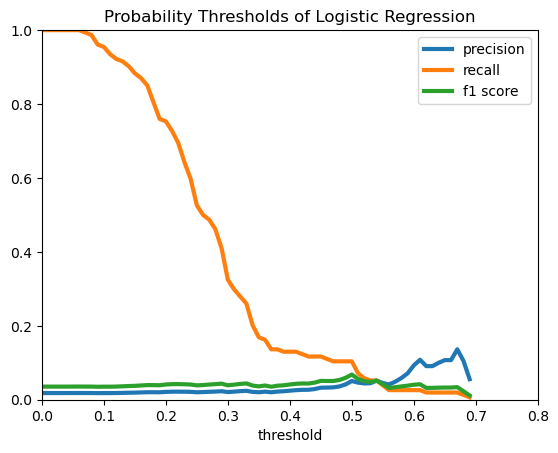

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

steps = [('over', SMOTE(random_state=1)), #sampling_strategy=0.2, 
         #('under', RandomUnderSampler(sampling_strategy=0.5)),
         ('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      solver='sag', C=0.01))]

model_lr = Pipeline(steps).fit(X_train, y_train)
y_test_proba = model_lr.predict_proba(X_test)

prob_threashold(y_test_proba, y_test)
plt.title('Probability Thresholds of Logistic Regression')

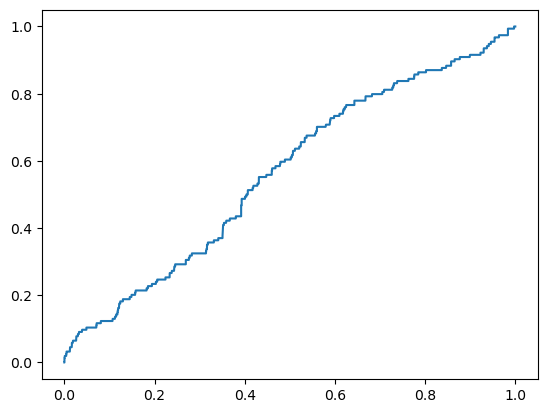

In [37]:
fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr, tpr)

In [108]:
y_test_proba

array([[0.79028475, 0.20971525],
       [0.81310794, 0.18689206],
       [0.81679972, 0.18320028],
       ...,
       [0.88554621, 0.11445379],
       [0.80491398, 0.19508602],
       [0.75757427, 0.24242573]])

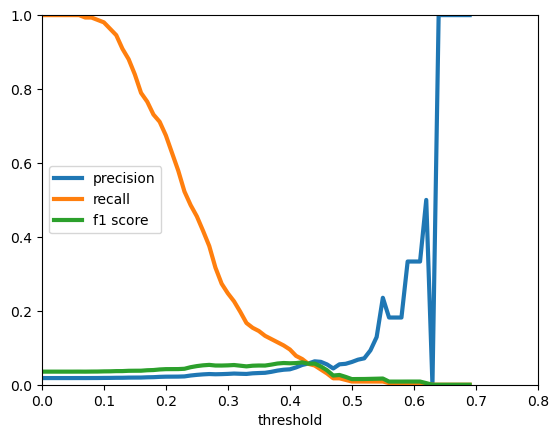

In [38]:
y_train_proba = model_lr.predict_proba(X_train)
prob_threashold(y_train_proba, y_train)

## Weighted classes -- compare with SMOTE
### Logistic Regression

[0.64506319 0.64985217 0.63441533 0.63385787 0.64488581 0.63821633
 0.63899445 0.64382266 0.6362159  0.63787563]
[0.56344879 0.53967031 0.64107915 0.62965681 0.56868282 0.60150003
 0.60789911 0.55904848 0.6307003  0.60321521]
Train_mean_score:  0.6403199342214515
Test_mean_score:  0.5944901015681212


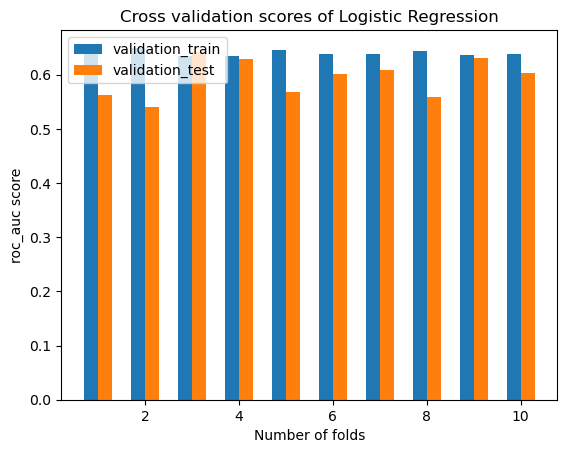

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      #solver='sag', C=0.01,
                                      class_weight='balanced'
                                     ))]

lr_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                       scoring=('roc_auc'),
                       return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        lr_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        lr_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of Logistic Regression')

print(lr_cv['train_score'])
print(lr_cv['test_score'])
print('Train_mean_score: ', np.mean(lr_cv['train_score']))
print('Test_mean_score: ', np.mean(lr_cv['test_score']))

Precision score:  0.026530612244897958
Recall score:  0.08441558441558442


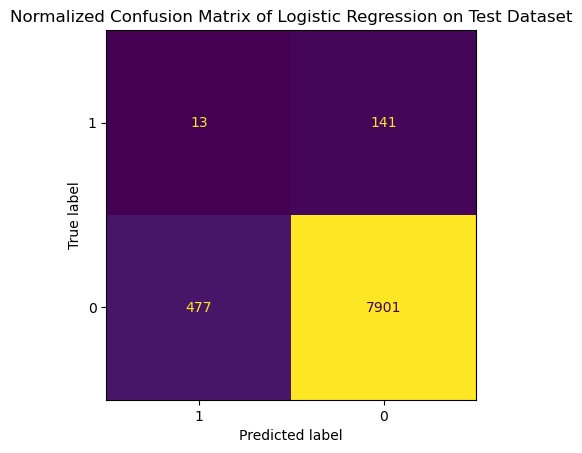

In [195]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

steps = [('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      #solver='sag', C=0.01,
                                      #class_weight='balanced'
                                      #class_weight={1: 30, 0: 1}
                                      class_weight={1: 30}
                                     ))]

model = sklearn.pipeline.Pipeline(steps).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0],
                                      colorbar=False, #cmap=plt.cm.flag,
                                      #normalize='all'
                                     )
plt.title('Normalized Confusion Matrix of Logistic Regression on Test Dataset')

y_test_pred = model.predict(X_test)
print('Precision score: ', precision_score(y_test, y_test_pred))
print('Recall score: ', recall_score(y_test, y_test_pred))

### XGBoost

In [76]:
scale_pos_weight = y.value_counts()[0]/y.value_counts()[1]

Precision score:  1.0
Recall score:  0.02097902097902098


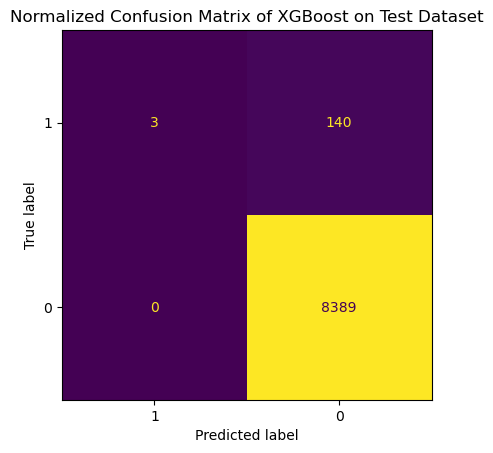

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [#('over', SMOTE(random_state=1)), #sampling_strategy=0.2, 
         #('under', RandomUnderSampler(sampling_strategy=0.5, random_state=1)),
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=0.001,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                 #scale_pos_weight=scale_pos_weight,
                                 scale_pos_weight=2
                                ))] 

model = sklearn.pipeline.Pipeline(steps).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0], #cmap=plt.cm.Paired,
                                      colorbar=False, 
                                      #normalize='all'
                                     )
plt.title('Normalized Confusion Matrix of XGBoost on Test Dataset')
print('Precision score: ', precision_score(y_test, y_test_pred))
print('Recall score: ', recall_score(y_test, y_test_pred))

[0.76053875 0.74873632 0.74036043 0.75938848 0.73889999 0.74396824
 0.72881788 0.73172261 0.75798875 0.75256796]
[0.66320664 0.59418682 0.6553708  0.63076815 0.66857003 0.67791621
 0.59733704 0.60201247 0.6445826  0.66227216]
Train_mean_score:  0.7462989424283153
Test_mean_score:  0.6396222917905426


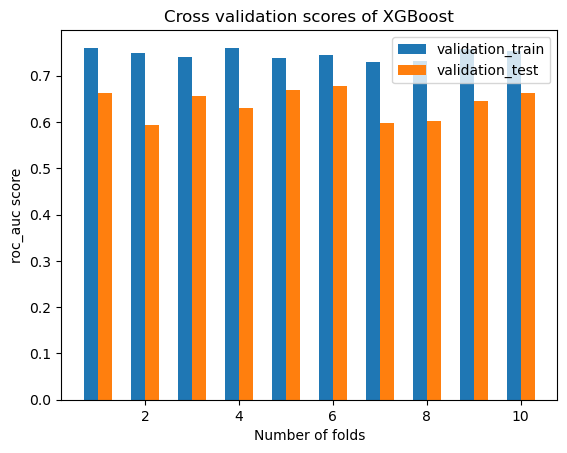

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [#('over', SMOTE(sampling_strategy=0.2, random_state=1)), 
         #('under', RandomUnderSampler(sampling_strategy=0.5, random_state=1)),
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=0.001,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                 #scale_pos_weight=scale_pos_weight,
                                 scale_pos_weight=6.5
                                ))] 

xgb_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                        scoring=('roc_auc'),
                        return_train_score=True)

plt.bar(np.arange(1, 11)-0.15,
        xgb_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        xgb_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of XGBoost')

print(xgb_cv['train_score'])
print(xgb_cv['test_score'])
print('Train_mean_score: ', np.mean(xgb_cv['train_score']))
print('Test_mean_score: ', np.mean(xgb_cv['test_score']))

### Weight selection

In [189]:
def plot_cvofweight(model_name, results, param_name, scoring, weight_range):

    plt.figure(figsize=(13, 13))
    plt.title('Evaluating different weights of ' + model_name, fontsize=16)
    
    plt.xlabel("weight")
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(0, 402)

    # Get the regular numpy array from the MaskedArray
    
    #X_axis = np.array(results['param_' + param_name].data, dtype=float)
    X_axis = weight_range
    
    y_max = 0
    
    for scorer, color in zip(sorted(scoring), ["g", "k", 'red']):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            
            if max(sample_score_mean) > y_max:
                y_max = max(sample_score_mean)
            
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    ax.set_ylim(0, y_max+0.1)
    plt.legend(loc="best")
    plt.grid(False)
    plt.xticks(X_axis)
    plt.show()

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
steps = [
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 max_depth=5, learning_rate=0.001,
                                 n_estimators=250, reg_lambda=1,
                                 subsample=0.8,
                                 #scale_pos_weight=scale_pos_weight,
                                 #scale_pos_weight=15
                                ))] 
                                 
param = {
         'model__scale_pos_weight': np.arange(1.5, scale_pos_weight, 5)
        }

scoring = {'AUC': 'roc_auc', 
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score, zero_division=0)
          }

model_tuned = GridSearchCV(
    estimator=sklearn.pipeline.Pipeline(steps),
    param_grid=param,
    scoring=scoring,
    refit="AUC",
    n_jobs = -1,
    cv=5,
    return_train_score=True).fit(X_train, y_train)

cv_results = model_tuned.cv_results_
#print('Tunning results: ', model_tuned.best_params_)
#print('Tunning results of XGboost: ', model_tuned.best_score_)

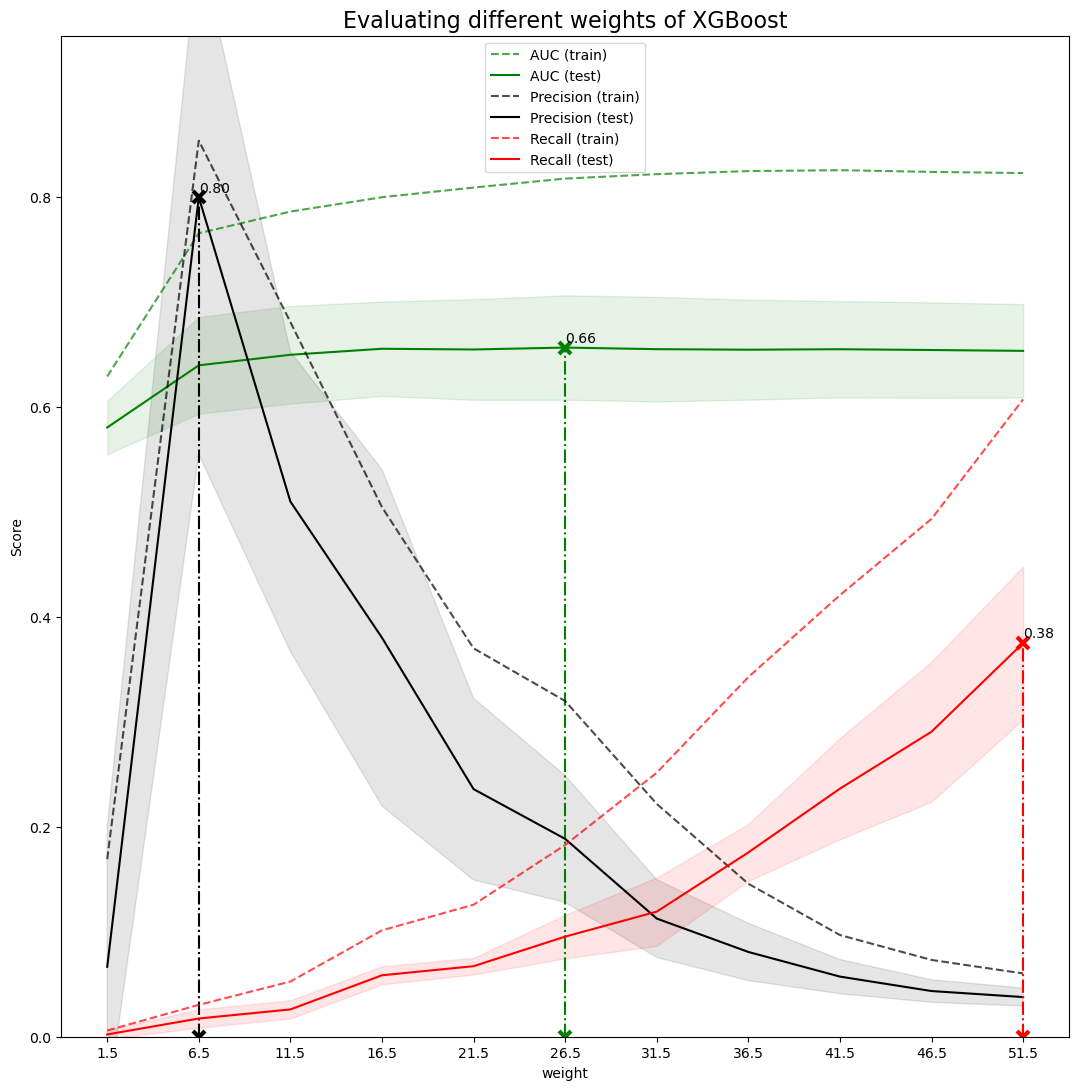

In [193]:
plot_cvofweight('XGBoost', cv_results, 'model__scale_pos_weight', scoring, np.arange(1.5, scale_pos_weight, 5))

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
steps = [
         ('scaler', scaler),
         ('model', LogisticRegression(n_jobs=-1, random_state=1, max_iter=100000, tol=0.001, 
                                      #solver='sag', C=0.01,
                                      #class_weight={1: 30}
                                     ))]
                                 
param = {
         'model__class_weight': [{1: 1.5}, {1: 6.5}, {1: 11.5}, {1: 16.5}, {1: 21.5}, 
                                 {1: 26.5}, {1: 31.5}, {1: 36.5}, {1: 41.5}, {1: 46.5}, {1: 51.5}
                                ]
        }

scoring = {'AUC': 'roc_auc', 
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score, zero_division=0)
          }

model_tuned = GridSearchCV(
    estimator=sklearn.pipeline.Pipeline(steps),
    param_grid=param,
    scoring=scoring,
    refit="AUC",
    n_jobs = -1,
    cv=5,
    return_train_score=True).fit(X_train, y_train)

cv_results = model_tuned.cv_results_
#print('Tunning results: ', model_tuned.best_params_)
#print('Tunning results of XGboost: ', model_tuned.best_score_)

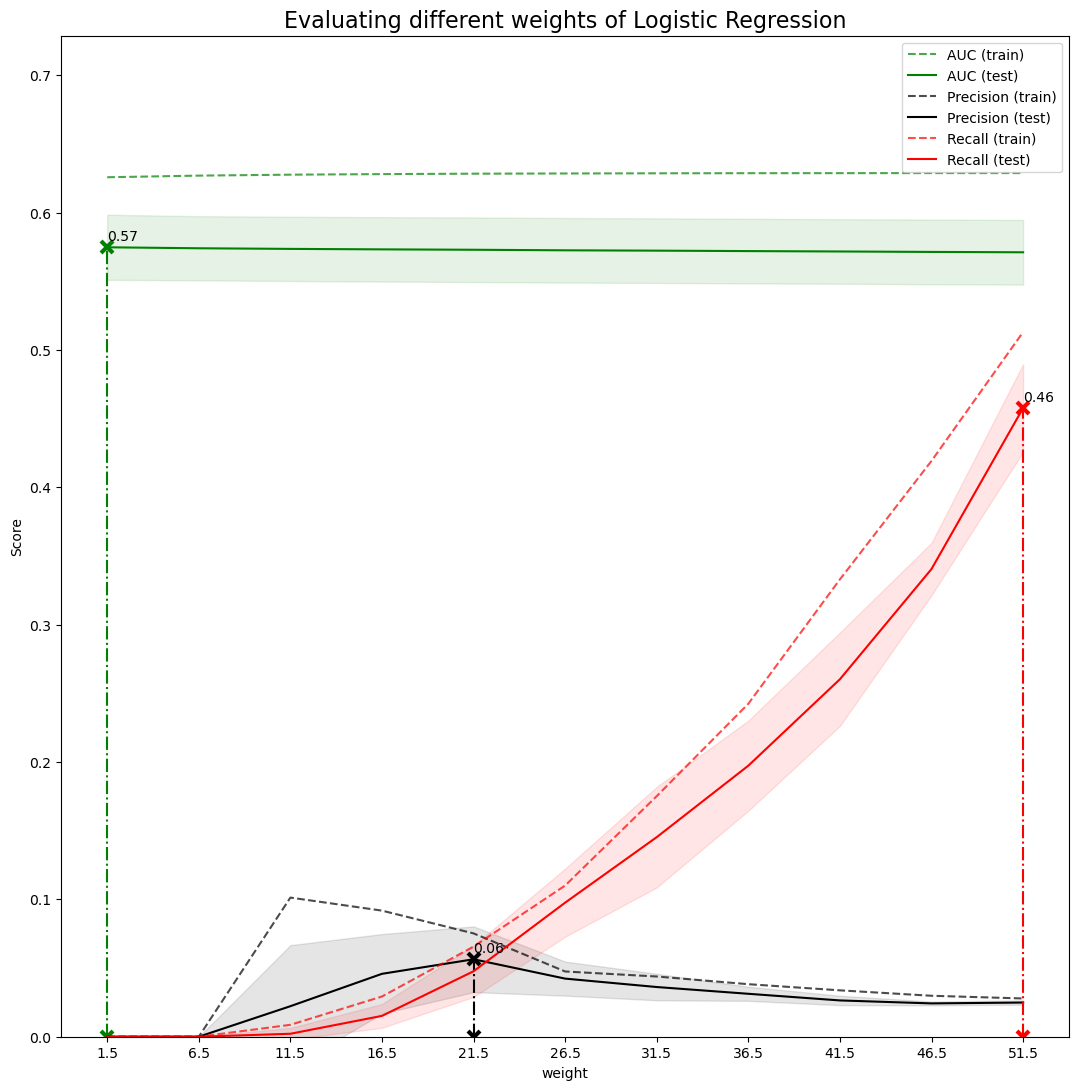

In [190]:
plot_cvofweight('Logistic Regression', cv_results, 'model__class_weight', scoring, np.arange(1.5, 56.5, 5))